In [4]:
import numpy as np
import numpyro as npr
import numpyro.distributions as dist
from jax import random
from numpyro.infer import MCMC, NUTS
from scipy.special import expit
import jax.numpy as jnp
import jax.scipy.special as jss
import arviz as az
import matplotlib.pyplot as plt
import multiprocessing as mp
import pandas as pd
import seaborn as sns
from numpyro.infer.reparam import TransformReparam

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [6]:
sns.set()

In [7]:
npr.set_host_device_count(mp.cpu_count())

# First toy model

## Data

In [21]:
# Seed
np.random.seed(123)

# Parameterization
mu = 6
sg_theta = 0.5
sg_u = 3
sg_w = 5

n_u = 20   # Number of users
n_w = 20   # Number of words
n_o = 100  # Number of obs per user per word

U = np.random.normal(0, sg_u, size=n_u)   # User ability
W = np.random.normal(0, sg_w, size=n_w)   # Item difficulty

n_obs = n_w*n_u*n_o
u = np.zeros(n_obs, dtype=int)
w = np.zeros(n_obs, dtype=int)
idx = 0
for i_w in range(n_w):
    for i_u in range(n_u):
        u[idx:idx+n_o] = i_u
        w[idx:idx+n_o] = i_w
        idx += n_o

theta = np.random.normal(mu + U[u] + W[w], sg_theta)

In [22]:
np.mean(theta)

4.9412931828600914

## Define the model

In [34]:
def model():
    
    sg_w = npr.sample("sg_w", dist.InverseGamma(1, 1))
    sg_u = npr.sample("sg_u", dist.InverseGamma(1, 1))
    sg_theta = npr.sample("sg_theta", dist.InverseGamma(1, 1))
    mu = npr.sample("mu", dist.Normal(0, 10));
    
    with npr.plate("user", n_u):
        U = npr.sample("U", 
                       dist.TransformedDistribution(dist.Normal(0., 1.), 
                                                    dist.transforms.AffineTransform(0, sg_u)))
    
    with npr.plate("word", n_w):
        W = npr.sample("W", 
                       dist.TransformedDistribution(dist.Normal(0., 1.), 
                                                    dist.transforms.AffineTransform(0, sg_w)))
    
    with npr.plate("n_obs", n_obs):
        npr.sample(f"theta", 
                   dist.TransformedDistribution(dist.Normal(0., 1.), 
                                                dist.transforms.AffineTransform(mu + U[u] + W[w], sg_theta)),
                   obs=theta)
    

In [35]:
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_warmup=1000, num_samples=1000, num_chains=1, progress_bar=True)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key)

sample: 100%|██████████| 2000/2000 [04:30<00:00,  7.39it/s, 159 steps of size 4.02e-03. acc. prob=0.93] 


In [36]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      U[0]     -3.49      0.74     -3.60     -4.61     -2.45     10.79      1.00
      U[1]      2.72      0.74      2.62      1.61      3.75     10.81      1.00
      U[2]      0.59      0.74      0.48     -0.53      1.62     10.81      1.00
      U[3]     -4.79      0.74     -4.89     -5.92     -3.78     10.81      1.00
      U[4]     -1.99      0.74     -2.09     -3.10     -0.95     10.81      1.00
      U[5]      4.67      0.74      4.57      3.56      5.70     10.82      1.00
      U[6]     -7.55      0.74     -7.66     -8.69     -6.53     10.80      1.00
      U[7]     -1.54      0.74     -1.64     -2.66     -0.50     10.79      1.00
      U[8]      3.54      0.74      3.44      2.43      4.58     10.81      1.00
      U[9]     -2.85      0.74     -2.96     -3.96     -1.82     10.82      1.00
     U[10]     -2.31      0.74     -2.42     -3.45     -1.30     10.81      1.00
     U[11]     -0.56      0

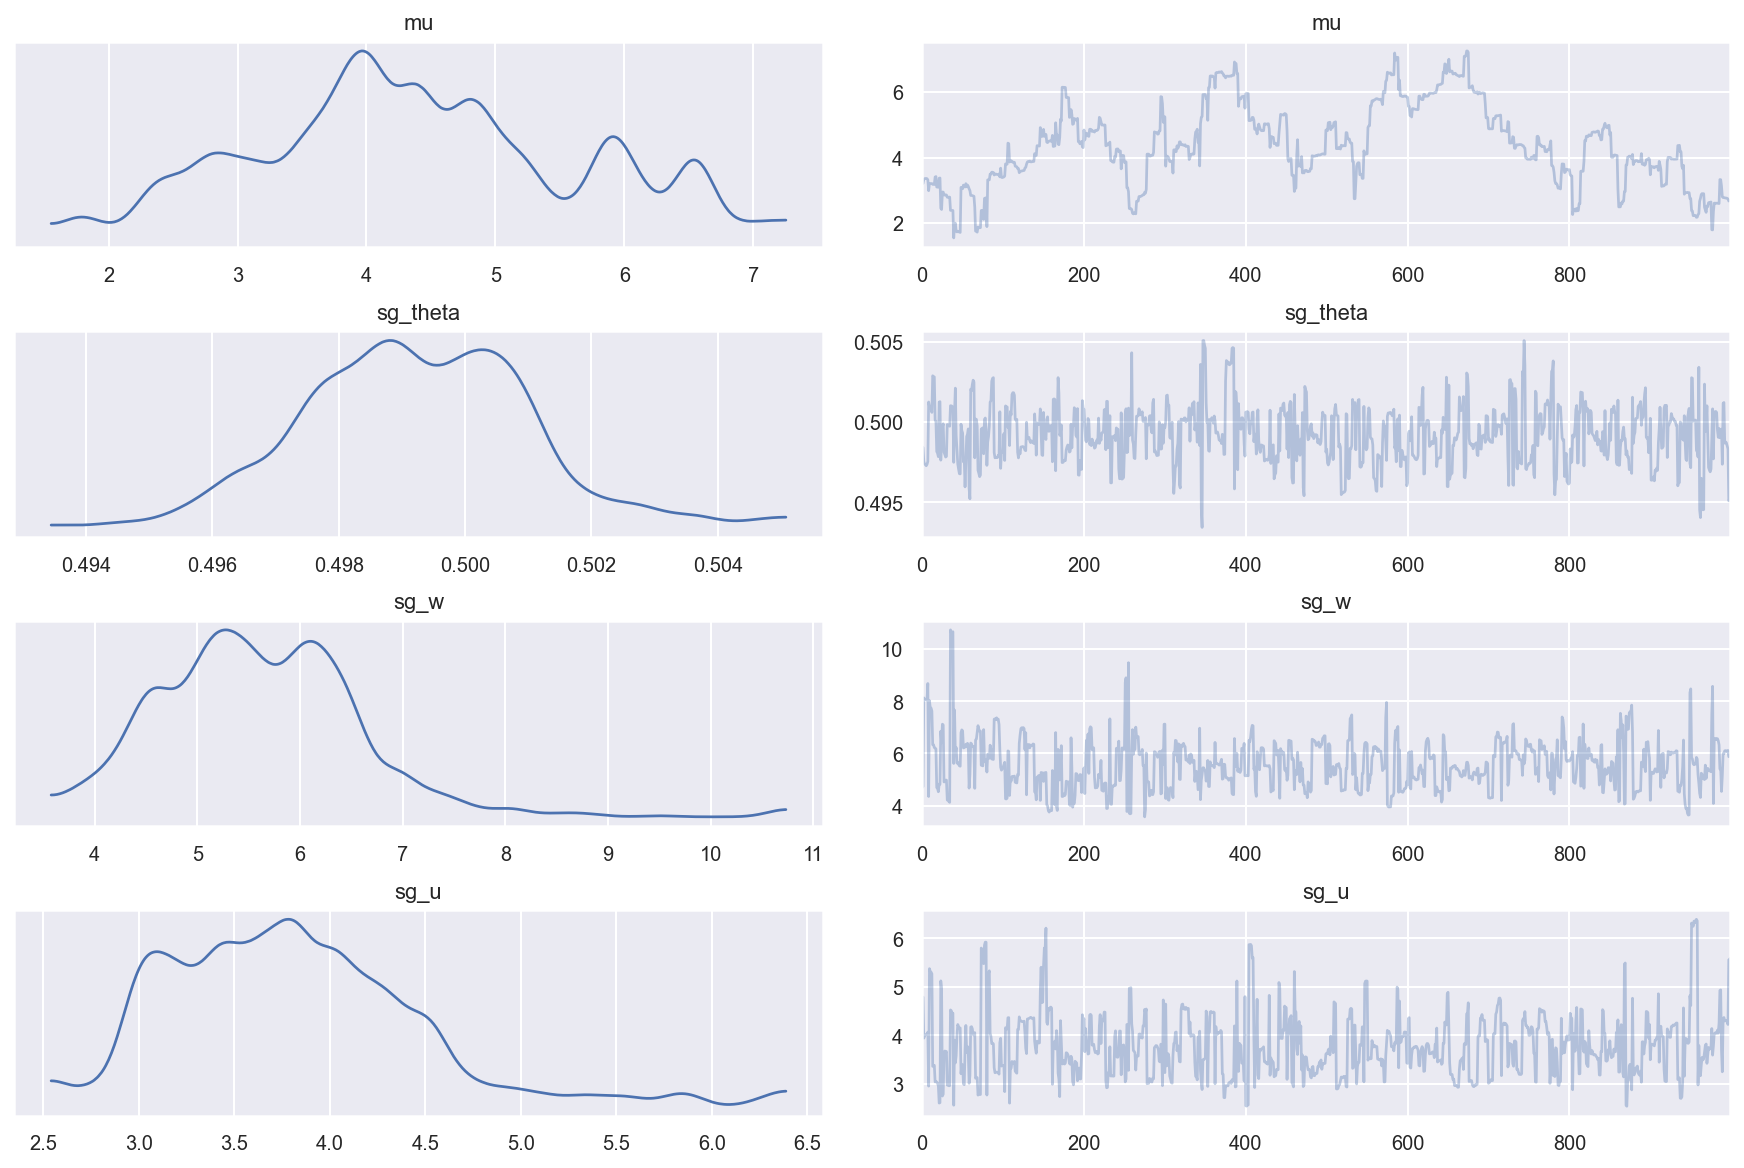

In [37]:
trace = az.from_numpyro(mcmc)
az.plot_trace(trace, var_names=['mu', 'sg_theta', 'sg_w', 'sg_u']);

# Second toy model

## Define model

In [18]:
def model(n_obs, n_u, n_w, d, y):
    sg_w = npr.sample("sg_w", dist.InverseGamma(1, 1))
    sg_u = npr.sample("sg_u", dist.InverseGamma(1, 1))
    sg_theta = npr.sample("sg_theta", dist.InverseGamma(1, 1))
    mu = npr.sample("mu", dist.Normal(0, 10));
    
    with npr.plate("user", n_u):
        U = npr.sample("U", 
                       dist.TransformedDistribution(
                           dist.Normal(0., 1.), 
                           dist.transforms.AffineTransform(0, sg_u)))
    
    with npr.plate("word", n_w):
        W = npr.sample("W", 
                       dist.TransformedDistribution(
                           dist.Normal(0., 1.), 
                           dist.transforms.AffineTransform(0, sg_w)))
    
    with npr.plate("n_obs", n_obs):
        mu_theta = mu + U[u] + W[w]
        theta = npr.sample("theta", 
                           dist.TransformedDistribution(
                               dist.Normal(0., 1.), 
                               [dist.transforms.AffineTransform(mu_theta, sg_theta),
                                dist.transforms.ExpTransform()]))
        
        logp = -theta * d
        p = jnp.exp(exponent)
        logits = logp - jnp.log(1-p+jnp.finfo(float).eps)
        npr.sample("obs", dist.Bernoulli(logits=logits), obs=y)

## Create data

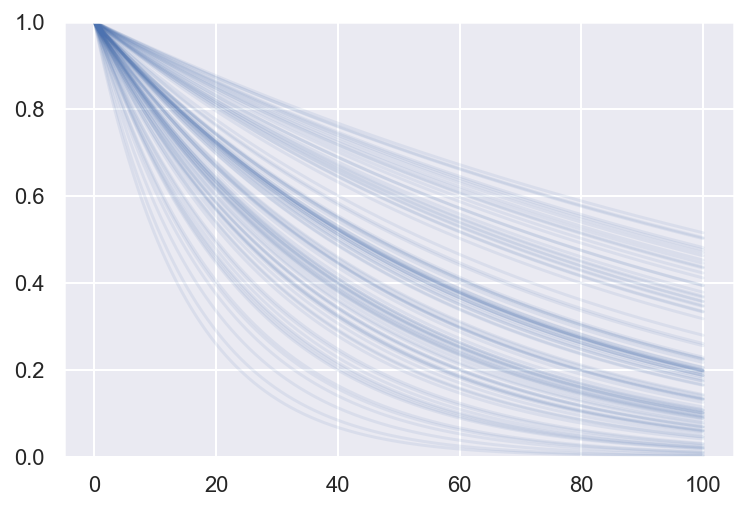

In [19]:
theta = np.random.normal(-4, 0.5, size=100)

fig, ax = plt.subplots()

for th in theta:
    x = np.linspace(0, 100, 1000)
    p = np.exp(-np.exp(th)*x)
    ax.plot(x, p, color='C0', alpha=0.1)
ax.set_ylim(0, 1);

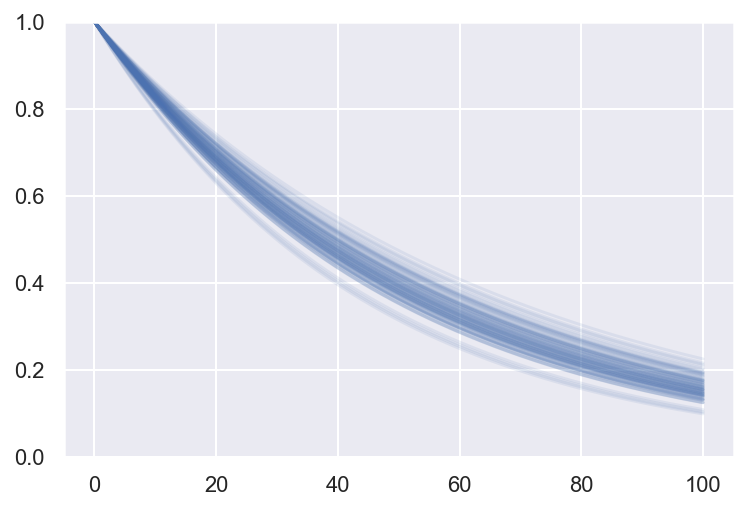

In [20]:
theta = np.random.normal(-4, 0.1, size=100)

fig, ax = plt.subplots()

for th in theta:
    x = np.linspace(0, 100, 1000)
    p = np.exp(-np.exp(th)*x)
    ax.plot(x, p, color='C0', alpha=0.1)
ax.set_ylim(0, 1);

In [21]:
np.random.seed(123)  # Seed

mu = -4
sg_theta = 0.001
sg_u = 0.1
sg_w = 0.5

n_u = 20    # Number of users
n_w = 20    # Number of words
n_o = 100    # Number of obs for one user and one word
n_obs = n_w*n_u*n_o

u = np.zeros(shape=n_obs, dtype=int)
w = np.zeros(shape=n_obs, dtype=int)

idx = 0
for i_w in range(n_w):
    for i_u in range(n_u):
        u[idx:idx+n_o] = i_u
        w[idx:idx+n_o] = i_w
        idx += n_o

U = np.random.normal(0, sg_u, size=n_u)   # User ability
W = np.random.normal(0, sg_w, size=n_w)   # Item difficulty
d = np.random.uniform(0, 100, size=n_obs) # Spacing
theta = np.random.normal(mu + U[u] + W[w], sg_theta)
rate = np.exp(theta)
exponent = - rate * d
p = np.exp(exponent)
rd = np.random.random(size=n_obs)
y = (p > rd).astype(int)
        
data = {'n_obs': n_obs, 'n_u': n_u, 'n_w': n_w, 'd': d, 'y': y}

In [22]:
print(np.mean(p), np.max(p), np.min(p))
print(np.mean(y), np.min(y), np.max(y))

0.49230919678788687 0.9998737699785589 0.00874143040528058
0.49525 0 1


## Run MCMC

In [23]:
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_warmup=1000, num_samples=1000, num_chains=1, progress_bar=True)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, **data)

sample: 100%|██████████| 2000/2000 [14:09<00:00,  2.35it/s, 255 steps of size 1.30e-02. acc. prob=0.92]


In [24]:
mcmc.print_summary()


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
        U[0]     -0.08      0.06     -0.08     -0.17      0.01     55.35      1.00
        U[1]      0.11      0.06      0.11      0.01      0.22     32.14      1.00
        U[2]     -0.05      0.07     -0.05     -0.17      0.06     29.24      1.04
        U[3]     -0.08      0.07     -0.08     -0.19      0.02     39.11      1.02
        U[4]     -0.12      0.06     -0.11     -0.22     -0.01     36.31      1.01
        U[5]      0.16      0.07      0.16      0.04      0.27     34.66      1.00
        U[6]     -0.25      0.07     -0.26     -0.37     -0.13     23.23      1.03
        U[7]     -0.05      0.06     -0.05     -0.15      0.04     60.27      1.02
        U[8]      0.18      0.06      0.18      0.09      0.28     78.68      1.00
        U[9]     -0.07      0.06     -0.07     -0.18      0.02     54.65      1.04
       U[10]     -0.09      0.07     -0.09     -0.20      0.03     16.71      1.29
   

 theta[1740]      0.03      0.01      0.03      0.02      0.05    954.96      1.00
 theta[1741]      0.03      0.01      0.03      0.02      0.05    456.23      1.00
 theta[1742]      0.03      0.01      0.03      0.02      0.05    458.49      1.01
 theta[1743]      0.03      0.01      0.03      0.02      0.05    981.09      1.00
 theta[1744]      0.03      0.01      0.03      0.02      0.05    591.58      1.00
 theta[1745]      0.03      0.01      0.03      0.02      0.05    748.86      1.00
 theta[1746]      0.03      0.01      0.03      0.02      0.05    855.96      1.00
 theta[1747]      0.03      0.01      0.03      0.02      0.05   1474.04      1.00
 theta[1748]      0.04      0.01      0.03      0.02      0.05    656.60      1.00
 theta[1749]      0.04      0.01      0.03      0.02      0.05    473.67      1.00
 theta[1750]      0.03      0.01      0.03      0.01      0.04   1360.36      1.00
 theta[1751]      0.03      0.01      0.03      0.02      0.05    936.53      1.01
 the

 theta[3239]      0.05      0.02      0.05      0.02      0.07   1168.30      1.00
 theta[3240]      0.05      0.02      0.04      0.02      0.07   1071.28      1.00
 theta[3241]      0.05      0.02      0.04      0.02      0.07   1148.16      1.00
 theta[3242]      0.04      0.01      0.04      0.02      0.07   1192.63      1.00
 theta[3243]      0.05      0.02      0.05      0.02      0.07    950.71      1.00
 theta[3244]      0.05      0.02      0.05      0.02      0.07    983.62      1.00
 theta[3245]      0.05      0.02      0.05      0.02      0.07    865.85      1.00
 theta[3246]      0.05      0.02      0.04      0.02      0.07    802.16      1.00
 theta[3247]      0.05      0.02      0.05      0.02      0.07   1112.86      1.01
 theta[3248]      0.05      0.01      0.05      0.02      0.07   1226.93      1.00
 theta[3249]      0.05      0.02      0.04      0.02      0.07   1049.11      1.00
 theta[3250]      0.05      0.02      0.05      0.03      0.07    988.49      1.00
 the

 theta[4739]      0.01      0.00      0.01      0.00      0.02    389.53      1.00
 theta[4740]      0.01      0.00      0.01      0.01      0.01    647.38      1.00
 theta[4741]      0.01      0.00      0.01      0.00      0.02    381.23      1.00
 theta[4742]      0.01      0.00      0.01      0.00      0.02    513.92      1.00
 theta[4743]      0.01      0.00      0.01      0.00      0.01    556.00      1.00
 theta[4744]      0.01      0.00      0.01      0.00      0.02   1214.97      1.00
 theta[4745]      0.01      0.00      0.01      0.01      0.01    795.93      1.00
 theta[4746]      0.01      0.00      0.01      0.01      0.02    563.75      1.00
 theta[4747]      0.01      0.00      0.01      0.01      0.02    800.43      1.00
 theta[4748]      0.01      0.00      0.01      0.00      0.01    829.39      1.00
 theta[4749]      0.01      0.00      0.01      0.01      0.02    523.48      1.00
 theta[4750]      0.01      0.00      0.01      0.01      0.02    485.31      1.00
 the

 theta[6238]      0.03      0.01      0.03      0.02      0.05    473.97      1.00
 theta[6239]      0.03      0.01      0.03      0.02      0.05    419.16      1.00
 theta[6240]      0.03      0.01      0.03      0.02      0.05    663.79      1.01
 theta[6241]      0.04      0.01      0.03      0.02      0.05    767.49      1.00
 theta[6242]      0.03      0.01      0.03      0.02      0.05    439.00      1.00
 theta[6243]      0.03      0.01      0.03      0.01      0.05    559.07      1.01
 theta[6244]      0.03      0.01      0.03      0.02      0.05    817.01      1.00
 theta[6245]      0.03      0.01      0.03      0.02      0.05    653.16      1.00
 theta[6246]      0.03      0.01      0.03      0.02      0.05    592.41      1.00
 theta[6247]      0.03      0.01      0.03      0.02      0.05    435.80      1.00
 theta[6248]      0.03      0.01      0.03      0.02      0.05    757.28      1.00
 theta[6249]      0.03      0.01      0.03      0.02      0.05    475.75      1.00
 the

 theta[7738]      0.04      0.02      0.04      0.02      0.07    506.19      1.00
 theta[7739]      0.04      0.01      0.04      0.02      0.06    578.19      1.00
 theta[7740]      0.04      0.01      0.04      0.02      0.06    717.25      1.00
 theta[7741]      0.04      0.01      0.04      0.02      0.06   1230.31      1.00
 theta[7742]      0.04      0.02      0.04      0.02      0.07    695.53      1.00
 theta[7743]      0.04      0.01      0.04      0.02      0.06    709.06      1.00
 theta[7744]      0.04      0.01      0.04      0.02      0.06    950.54      1.00
 theta[7745]      0.04      0.02      0.04      0.02      0.07    876.91      1.00
 theta[7746]      0.04      0.02      0.04      0.02      0.07   1281.91      1.00
 theta[7747]      0.04      0.01      0.04      0.02      0.07    969.70      1.00
 theta[7748]      0.04      0.02      0.04      0.02      0.07   1152.51      1.00
 theta[7749]      0.04      0.01      0.04      0.02      0.06    618.93      1.00
 the

 theta[9237]      0.01      0.00      0.01      0.01      0.02    710.78      1.00
 theta[9238]      0.01      0.00      0.01      0.01      0.02    835.63      1.00
 theta[9239]      0.01      0.00      0.01      0.01      0.02    431.48      1.00
 theta[9240]      0.01      0.00      0.01      0.01      0.02    368.77      1.00
 theta[9241]      0.01      0.00      0.01      0.01      0.02    501.70      1.00
 theta[9242]      0.01      0.00      0.01      0.01      0.02    462.63      1.00
 theta[9243]      0.01      0.00      0.01      0.01      0.02    376.64      1.00
 theta[9244]      0.01      0.00      0.01      0.01      0.02    427.46      1.00
 theta[9245]      0.01      0.00      0.01      0.01      0.02    476.32      1.00
 theta[9246]      0.01      0.00      0.01      0.01      0.02    356.23      1.00
 theta[9247]      0.01      0.00      0.01      0.01      0.02    507.99      1.00
 theta[9248]      0.01      0.00      0.01      0.01      0.02    349.84      1.00
 the

theta[10737]      0.01      0.00      0.01      0.01      0.02    626.79      1.01
theta[10738]      0.01      0.00      0.01      0.01      0.02    561.97      1.00
theta[10739]      0.01      0.00      0.01      0.01      0.02    661.11      1.00
theta[10740]      0.01      0.00      0.01      0.01      0.02    581.46      1.00
theta[10741]      0.01      0.00      0.01      0.01      0.02    531.17      1.00
theta[10742]      0.01      0.00      0.01      0.01      0.02    349.27      1.01
theta[10743]      0.01      0.00      0.01      0.01      0.02    839.55      1.00
theta[10744]      0.01      0.00      0.01      0.01      0.02    331.59      1.01
theta[10745]      0.01      0.00      0.01      0.01      0.02    930.11      1.00
theta[10746]      0.01      0.00      0.01      0.01      0.02    484.17      1.00
theta[10747]      0.01      0.00      0.01      0.01      0.02    471.93      1.00
theta[10748]      0.01      0.00      0.01      0.01      0.02    408.10      1.00
thet

theta[12236]      0.03      0.01      0.03      0.01      0.04    819.06      1.01
theta[12237]      0.03      0.01      0.03      0.02      0.05    389.77      1.00
theta[12238]      0.03      0.01      0.03      0.01      0.04    962.73      1.01
theta[12239]      0.03      0.01      0.03      0.02      0.04    604.37      1.01
theta[12240]      0.03      0.01      0.03      0.01      0.05    707.43      1.01
theta[12241]      0.03      0.01      0.03      0.01      0.04    250.22      1.02
theta[12242]      0.03      0.01      0.03      0.02      0.05    760.42      1.00
theta[12243]      0.03      0.01      0.03      0.01      0.05    430.27      1.01
theta[12244]      0.03      0.01      0.03      0.02      0.05    800.95      1.00
theta[12245]      0.03      0.01      0.03      0.01      0.04    686.69      1.01
theta[12246]      0.03      0.01      0.03      0.02      0.04    633.25      1.01
theta[12247]      0.03      0.01      0.02      0.01      0.04    348.58      1.02
thet

theta[13736]      0.04      0.01      0.04      0.02      0.06    757.26      1.01
theta[13737]      0.04      0.01      0.04      0.02      0.05    830.08      1.01
theta[13738]      0.04      0.01      0.04      0.02      0.06    698.71      1.01
theta[13739]      0.04      0.01      0.04      0.02      0.05    760.15      1.00
theta[13740]      0.04      0.01      0.04      0.02      0.06    884.01      1.01
theta[13741]      0.04      0.01      0.03      0.02      0.05    793.07      1.00
theta[13742]      0.04      0.01      0.04      0.02      0.06    644.63      1.01
theta[13743]      0.04      0.01      0.04      0.02      0.06    492.37      1.01
theta[13744]      0.04      0.01      0.04      0.02      0.06    523.37      1.00
theta[13745]      0.04      0.01      0.03      0.02      0.05    786.57      1.00
theta[13746]      0.04      0.01      0.04      0.02      0.06   1083.65      1.01
theta[13747]      0.04      0.01      0.04      0.02      0.06    674.03      1.01
thet

theta[15235]      0.01      0.00      0.01      0.00      0.01    309.35      1.01
theta[15236]      0.01      0.00      0.01      0.01      0.02    147.84      1.01
theta[15237]      0.01      0.00      0.01      0.01      0.01    154.80      1.01
theta[15238]      0.01      0.00      0.01      0.00      0.02    589.80      1.01
theta[15239]      0.01      0.00      0.01      0.01      0.01    159.65      1.02
theta[15240]      0.01      0.00      0.01      0.00      0.01    675.50      1.00
theta[15241]      0.01      0.00      0.01      0.00      0.01    207.76      1.01
theta[15242]      0.01      0.00      0.01      0.00      0.01    152.52      1.01
theta[15243]      0.01      0.00      0.01      0.00      0.01    318.36      1.01
theta[15244]      0.01      0.00      0.01      0.00      0.01    384.70      1.01
theta[15245]      0.01      0.00      0.01      0.00      0.02    179.45      1.02
theta[15246]      0.01      0.00      0.01      0.00      0.01    316.16      1.01
thet

theta[16735]      0.02      0.01      0.02      0.01      0.03   1097.69      1.00
theta[16736]      0.02      0.01      0.02      0.01      0.03    565.64      1.00
theta[16737]      0.02      0.01      0.02      0.01      0.03    689.99      1.00
theta[16738]      0.02      0.01      0.02      0.01      0.03    653.14      1.00
theta[16739]      0.02      0.01      0.01      0.01      0.02    689.80      1.00
theta[16740]      0.02      0.01      0.02      0.01      0.03    818.87      1.00
theta[16741]      0.02      0.01      0.02      0.01      0.02   1113.34      1.00
theta[16742]      0.02      0.01      0.02      0.01      0.03    804.43      1.00
theta[16743]      0.02      0.01      0.02      0.01      0.03    582.99      1.00
theta[16744]      0.02      0.01      0.02      0.01      0.03    567.98      1.00
theta[16745]      0.02      0.01      0.02      0.01      0.02   1534.50      1.00
theta[16746]      0.02      0.01      0.02      0.01      0.02    854.37      1.00
thet

theta[18234]      0.01      0.00      0.01      0.01      0.02    514.78      1.00
theta[18235]      0.01      0.00      0.01      0.01      0.02    555.08      1.01
theta[18236]      0.01      0.00      0.01      0.01      0.02    555.31      1.01
theta[18237]      0.01      0.00      0.01      0.01      0.02    349.32      1.00
theta[18238]      0.01      0.00      0.01      0.01      0.02    536.37      1.00
theta[18239]      0.01      0.00      0.01      0.01      0.02    479.52      1.00
theta[18240]      0.01      0.00      0.01      0.01      0.02    456.82      1.00
theta[18241]      0.01      0.00      0.01      0.01      0.02    599.49      1.00
theta[18242]      0.01      0.00      0.01      0.01      0.02    402.67      1.00
theta[18243]      0.01      0.00      0.01      0.00      0.02    638.07      1.00
theta[18244]      0.01      0.00      0.01      0.01      0.02    398.84      1.00
theta[18245]      0.01      0.00      0.01      0.01      0.02    609.95      1.00
thet

theta[19734]      0.02      0.00      0.01      0.01      0.02    557.20      1.01
theta[19735]      0.02      0.01      0.01      0.01      0.02    625.73      1.00
theta[19736]      0.02      0.01      0.01      0.01      0.02   1160.90      1.00
theta[19737]      0.02      0.01      0.01      0.01      0.02    600.34      1.00
theta[19738]      0.01      0.00      0.01      0.01      0.02    402.14      1.00
theta[19739]      0.01      0.00      0.01      0.01      0.02    602.41      1.01
theta[19740]      0.02      0.01      0.01      0.01      0.02    602.31      1.00
theta[19741]      0.01      0.00      0.01      0.01      0.02   1224.79      1.00
theta[19742]      0.01      0.00      0.01      0.01      0.02    601.92      1.00
theta[19743]      0.01      0.01      0.01      0.01      0.02    581.17      1.00
theta[19744]      0.02      0.01      0.01      0.01      0.02    623.38      1.01
theta[19745]      0.01      0.00      0.01      0.01      0.02    687.51      1.00
thet

theta[21223]      0.02      0.01      0.02      0.01      0.03    605.19      1.00
theta[21224]      0.02      0.01      0.02      0.01      0.03    694.53      1.00
theta[21225]      0.02      0.01      0.02      0.01      0.03    790.01      1.00
theta[21226]      0.02      0.01      0.02      0.01      0.03    686.20      1.00
theta[21227]      0.02      0.01      0.02      0.01      0.02    991.93      1.00
theta[21228]      0.02      0.01      0.02      0.01      0.03    744.55      1.00
theta[21229]      0.02      0.01      0.02      0.01      0.03    620.94      1.00
theta[21230]      0.02      0.01      0.02      0.01      0.03    560.21      1.00
theta[21231]      0.02      0.01      0.02      0.01      0.03    670.56      1.00
theta[21232]      0.02      0.01      0.02      0.01      0.03   1263.48      1.00
theta[21233]      0.02      0.01      0.02      0.01      0.03   1012.47      1.00
theta[21234]      0.02      0.01      0.02      0.01      0.03    712.93      1.00
thet

theta[22524]      0.01      0.00      0.01      0.00      0.01    202.08      1.03
theta[22525]      0.01      0.00      0.01      0.00      0.01    170.75      1.03
theta[22526]      0.01      0.00      0.01      0.00      0.01    513.65      1.02
theta[22527]      0.01      0.00      0.01      0.00      0.01    279.38      1.02
theta[22528]      0.01      0.00      0.01      0.00      0.01    155.45      1.03
theta[22529]      0.01      0.00      0.01      0.00      0.01    483.21      1.02
theta[22530]      0.01      0.00      0.01      0.00      0.01    318.48      1.02
theta[22531]      0.01      0.00      0.01      0.00      0.01    267.75      1.02
theta[22532]      0.01      0.00      0.01      0.00      0.01    245.69      1.02
theta[22533]      0.01      0.00      0.01      0.00      0.01    170.77      1.03
theta[22534]      0.01      0.00      0.01      0.00      0.01    512.55      1.03
theta[22535]      0.01      0.00      0.01      0.00      0.01    438.04      1.02
thet

theta[23877]      0.01      0.00      0.01      0.00      0.01    495.37      1.02
theta[23878]      0.01      0.00      0.01      0.00      0.01    334.53      1.02
theta[23879]      0.01      0.00      0.01      0.00      0.01    308.83      1.02
theta[23880]      0.01      0.00      0.01      0.00      0.01    141.51      1.03
theta[23881]      0.01      0.00      0.01      0.00      0.01    265.17      1.03
theta[23882]      0.01      0.00      0.01      0.00      0.01    352.16      1.01
theta[23883]      0.01      0.00      0.01      0.00      0.01    204.44      1.03
theta[23884]      0.01      0.00      0.01      0.00      0.01    362.95      1.02
theta[23885]      0.01      0.00      0.01      0.00      0.01    288.86      1.02
theta[23886]      0.01      0.00      0.01      0.00      0.01    241.81      1.02
theta[23887]      0.01      0.00      0.01      0.00      0.01    395.04      1.02
theta[23888]      0.01      0.00      0.01      0.00      0.01    392.49      1.01
thet

theta[25225]      0.01      0.00      0.01      0.00      0.01     75.23      1.01
theta[25226]      0.01      0.00      0.01      0.00      0.01    109.74      1.00
theta[25227]      0.01      0.00      0.01      0.00      0.01     91.33      1.01
theta[25228]      0.01      0.00      0.01      0.00      0.01     78.88      1.00
theta[25229]      0.01      0.00      0.01      0.00      0.02     99.11      1.00
theta[25230]      0.01      0.00      0.01      0.00      0.01     93.02      1.00
theta[25231]      0.01      0.00      0.01      0.00      0.01     91.21      1.01
theta[25232]      0.01      0.00      0.01      0.00      0.01     83.01      1.00
theta[25233]      0.01      0.00      0.01      0.00      0.01     83.14      1.01
theta[25234]      0.01      0.00      0.01      0.00      0.01    105.07      1.00
theta[25235]      0.01      0.00      0.01      0.00      0.01     94.68      1.00
theta[25236]      0.01      0.00      0.01      0.00      0.02    100.98      1.00
thet

theta[26329]      0.01      0.00      0.01      0.01      0.02    404.18      1.01
theta[26330]      0.01      0.00      0.01      0.01      0.02    357.40      1.01
theta[26331]      0.01      0.00      0.01      0.01      0.02    458.76      1.01
theta[26332]      0.01      0.00      0.01      0.01      0.02    455.27      1.00
theta[26333]      0.01      0.00      0.01      0.01      0.02    404.86      1.00
theta[26334]      0.01      0.00      0.01      0.01      0.02    576.96      1.01
theta[26335]      0.01      0.00      0.01      0.01      0.02    431.95      1.01
theta[26336]      0.01      0.00      0.01      0.01      0.02    266.79      1.01
theta[26337]      0.01      0.00      0.01      0.01      0.02    371.73      1.01
theta[26338]      0.01      0.00      0.01      0.01      0.02    331.94      1.01
theta[26339]      0.01      0.00      0.01      0.01      0.02    399.38      1.00
theta[26340]      0.01      0.00      0.01      0.01      0.02    213.71      1.01
thet

theta[27688]      0.02      0.01      0.02      0.01      0.03    566.37      1.00
theta[27689]      0.02      0.01      0.02      0.01      0.03    989.35      1.00
theta[27690]      0.02      0.01      0.02      0.01      0.03    714.87      1.00
theta[27691]      0.02      0.01      0.02      0.01      0.02    695.00      1.00
theta[27692]      0.02      0.01      0.02      0.01      0.03    734.61      1.00
theta[27693]      0.02      0.01      0.02      0.01      0.02    857.11      1.00
theta[27694]      0.02      0.00      0.01      0.01      0.02    664.16      1.00
theta[27695]      0.02      0.01      0.02      0.01      0.03    438.54      1.01
theta[27696]      0.02      0.01      0.02      0.01      0.03    870.89      1.00
theta[27697]      0.02      0.01      0.02      0.01      0.03    822.80      1.00
theta[27698]      0.02      0.01      0.02      0.01      0.02    572.85      1.00
theta[27699]      0.02      0.01      0.02      0.01      0.03    682.62      1.00
thet

theta[29730]      0.04      0.01      0.04      0.02      0.06    821.97      1.00
theta[29731]      0.04      0.01      0.04      0.02      0.06   1334.76      1.00
theta[29732]      0.04      0.01      0.04      0.02      0.06    912.90      1.01
theta[29733]      0.04      0.01      0.03      0.02      0.05    611.40      1.00
theta[29734]      0.04      0.01      0.04      0.02      0.06    672.92      1.00
theta[29735]      0.04      0.01      0.04      0.02      0.06    742.97      1.00
theta[29736]      0.04      0.01      0.04      0.02      0.06   1019.62      1.00
theta[29737]      0.04      0.01      0.03      0.02      0.05    959.26      1.00
theta[29738]      0.04      0.01      0.04      0.02      0.06   1103.98      1.00
theta[29739]      0.04      0.01      0.04      0.02      0.06   1029.81      1.00
theta[29740]      0.04      0.01      0.04      0.02      0.06   1364.32      1.00
theta[29741]      0.04      0.01      0.04      0.02      0.06    781.36      1.00
thet

theta[31230]      0.02      0.01      0.02      0.01      0.03    466.49      1.00
theta[31231]      0.02      0.01      0.02      0.01      0.03    534.47      1.00
theta[31232]      0.02      0.01      0.02      0.01      0.03    543.40      1.00
theta[31233]      0.02      0.01      0.02      0.01      0.03    740.39      1.00
theta[31234]      0.02      0.01      0.02      0.01      0.03   1119.99      1.00
theta[31235]      0.02      0.01      0.02      0.01      0.03    379.79      1.00
theta[31236]      0.02      0.01      0.02      0.01      0.03    494.66      1.00
theta[31237]      0.02      0.01      0.02      0.01      0.03    482.65      1.00
theta[31238]      0.02      0.01      0.02      0.01      0.03    470.15      1.00
theta[31239]      0.02      0.01      0.02      0.01      0.03    397.21      1.00
theta[31240]      0.02      0.01      0.02      0.01      0.03    678.07      1.00
theta[31241]      0.02      0.01      0.02      0.01      0.03    261.33      1.00
thet

theta[32729]      0.02      0.01      0.02      0.01      0.03    905.42      1.00
theta[32730]      0.02      0.01      0.02      0.01      0.03   1055.76      1.00
theta[32731]      0.02      0.01      0.02      0.01      0.03   1050.76      1.00
theta[32732]      0.02      0.01      0.02      0.01      0.02   1139.59      1.00
theta[32733]      0.02      0.01      0.02      0.01      0.03    804.45      1.00
theta[32734]      0.02      0.01      0.02      0.01      0.03   1007.08      1.00
theta[32735]      0.02      0.01      0.02      0.01      0.02   1352.24      1.00
theta[32736]      0.02      0.01      0.02      0.01      0.03   1168.17      1.00
theta[32737]      0.02      0.01      0.02      0.01      0.03    589.86      1.00
theta[32738]      0.02      0.01      0.02      0.01      0.03    867.68      1.00
theta[32739]      0.02      0.01      0.02      0.01      0.02   1275.63      1.00
theta[32740]      0.02      0.01      0.02      0.01      0.03    974.22      1.00
thet

theta[34229]      0.03      0.01      0.03      0.01      0.04   1064.09      1.00
theta[34230]      0.02      0.01      0.02      0.01      0.04    629.35      1.00
theta[34231]      0.03      0.01      0.03      0.01      0.04    616.72      1.00
theta[34232]      0.03      0.01      0.02      0.01      0.04    556.43      1.00
theta[34233]      0.02      0.01      0.02      0.01      0.03    954.15      1.00
theta[34234]      0.03      0.01      0.03      0.01      0.04    747.37      1.00
theta[34235]      0.03      0.01      0.02      0.01      0.04    712.83      1.00
theta[34236]      0.03      0.01      0.03      0.01      0.04    972.16      1.00
theta[34237]      0.03      0.01      0.02      0.01      0.04    694.06      1.00
theta[34238]      0.03      0.01      0.02      0.01      0.04    550.96      1.00
theta[34239]      0.03      0.01      0.03      0.01      0.04    423.17      1.00
theta[34240]      0.02      0.01      0.02      0.01      0.03    939.12      1.00
thet

theta[35728]      0.03      0.01      0.03      0.02      0.05    877.82      1.00
theta[35729]      0.03      0.01      0.03      0.02      0.05    752.25      1.00
theta[35730]      0.03      0.01      0.03      0.02      0.05   1310.37      1.00
theta[35731]      0.03      0.01      0.03      0.02      0.04    807.85      1.00
theta[35732]      0.03      0.01      0.03      0.02      0.05   1172.10      1.00
theta[35733]      0.03      0.01      0.03      0.02      0.05   1401.76      1.00
theta[35734]      0.03      0.01      0.03      0.02      0.05   1118.58      1.00
theta[35735]      0.03      0.01      0.03      0.02      0.05   1017.86      1.00
theta[35736]      0.03      0.01      0.03      0.02      0.05    807.53      1.00
theta[35737]      0.03      0.01      0.03      0.02      0.05   1295.75      1.00
theta[35738]      0.03      0.01      0.03      0.02      0.05    851.01      1.00
theta[35739]      0.03      0.01      0.03      0.02      0.05    955.34      1.00
thet

theta[37228]      0.01      0.00      0.01      0.01      0.02    340.95      1.00
theta[37229]      0.01      0.00      0.01      0.00      0.02    330.34      1.01
theta[37230]      0.01      0.00      0.01      0.00      0.02    389.75      1.01
theta[37231]      0.01      0.00      0.01      0.01      0.02    276.93      1.01
theta[37232]      0.01      0.00      0.01      0.01      0.02    410.22      1.00
theta[37233]      0.01      0.00      0.01      0.01      0.02    167.75      1.01
theta[37234]      0.01      0.00      0.01      0.01      0.02    243.02      1.00
theta[37235]      0.01      0.00      0.01      0.01      0.02    286.53      1.01
theta[37236]      0.01      0.00      0.01      0.01      0.02    196.80      1.01
theta[37237]      0.01      0.00      0.01      0.01      0.02    272.84      1.00
theta[37238]      0.01      0.00      0.01      0.01      0.02    216.02      1.01
theta[37239]      0.01      0.00      0.01      0.01      0.02    250.10      1.00
thet

theta[38727]      0.02      0.01      0.02      0.01      0.03    884.19      1.00
theta[38728]      0.02      0.01      0.02      0.01      0.03    911.45      1.00
theta[38729]      0.02      0.01      0.02      0.01      0.03    960.35      1.00
theta[38730]      0.02      0.01      0.02      0.01      0.03    781.42      1.00
theta[38731]      0.02      0.01      0.02      0.01      0.03    820.88      1.00
theta[38732]      0.02      0.01      0.02      0.01      0.03    548.00      1.00
theta[38733]      0.02      0.01      0.02      0.01      0.03    592.19      1.00
theta[38734]      0.02      0.01      0.02      0.01      0.03    898.62      1.00
theta[38735]      0.02      0.01      0.02      0.01      0.03    546.07      1.00
theta[38736]      0.02      0.01      0.02      0.01      0.03    429.50      1.00
theta[38737]      0.02      0.01      0.02      0.01      0.03    952.25      1.00
theta[38738]      0.02      0.01      0.02      0.01      0.03    427.73      1.00
thet

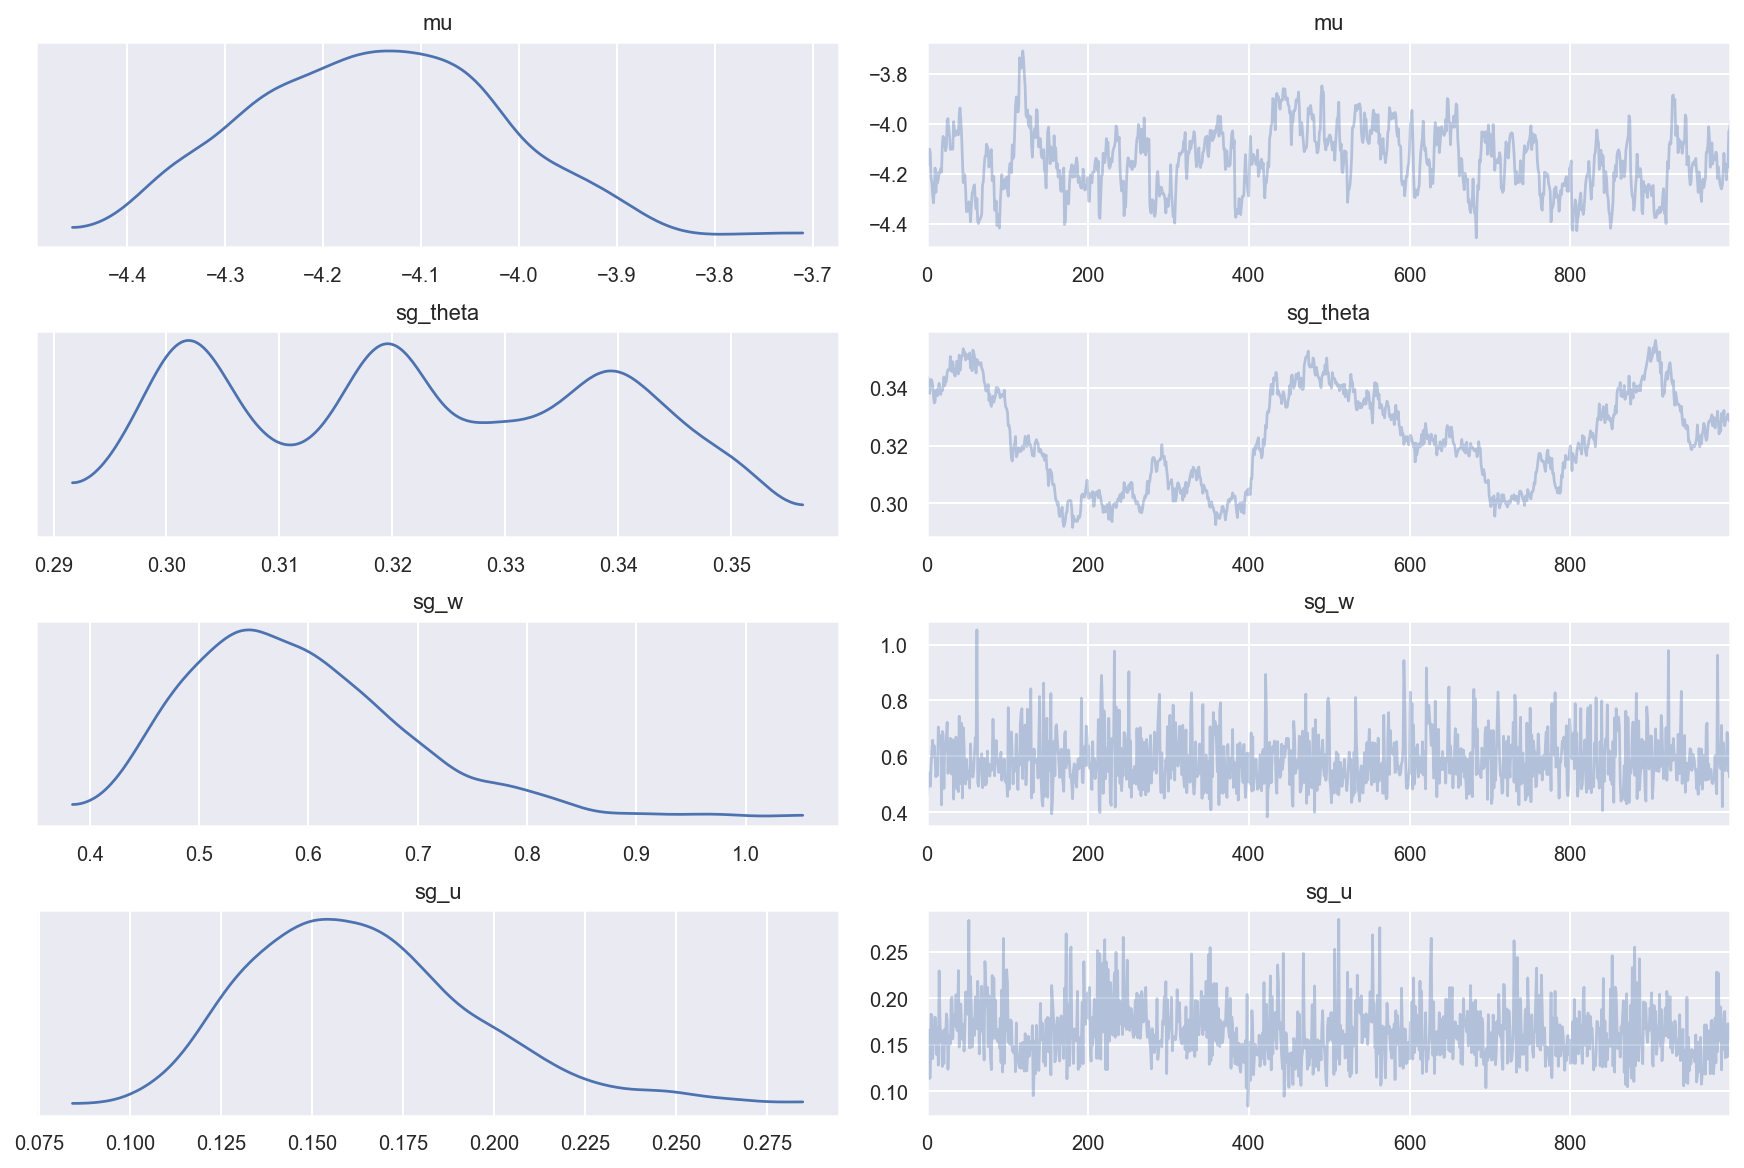

In [25]:
trace = az.from_numpyro(mcmc)
az.plot_trace(trace, var_names=['mu', 'sg_theta', 'sg_w', 'sg_u']);